In [1]:
import numpy as np
import numpy.linalg as la
import scipy as sp
import scipy.integrate as spint
import matplotlib.pyplot as plt

from rocketPy import Quaternion

In [2]:
class SimpleRocket():
    
    def __init__(self):
        
        self.m0 = 40;
        self.c = 2000;
        
        self.A_ref = np.pi*0.15**2/4;
        
        self.ax_roll = np.array([0,0,1])
        self.ax_pitch = np.array([0,1,0])
        self.ax_yaw = np.array([1,0,0])
        
        self.inertia_matrix = np.diag([100,100,10])
        
        self.C_A = 0.5
        self.C_Na = 4
        self.static_margin = 1.5
        
        # location of the cp relative to the cg of the rocket
        self.cp = - (2*(self.A_ref/np.pi)**0.5) * self.static_margin * self.ax_roll
        
        
    def dynamics(self, time, state):
        
        # need to return the forces and moments acting at the cg in body fixed axes.
        # z points towards the nose
        # x points to the right fin
        # y completes right hand coord system
        
        # m_dot is a scalar, negative if the mass is decreasing
        
        # compute thrust force
        f_thrust, m_dot = self.f_thrust(state)
        
        # compute axial drag force
        f_axial = self.f_axial(state)
        
        f_normal = self.f_normal(state)
        
        # sum forces
        # in body axes
        forces = f_thrust + f_axial + f_normal;

        # sum moments
        # in body axes
        moment_f_normal = np.cross(self.cp, f_normal)
        
        moments = np.array([0.,0.,0.])
        moments += moment_f_normal
        
        return forces, moments, m_dot
    
    
    def f_thrust(self, state):
        
        time = state.time
        
        if time < 3:
            f = 4000;
        else:
            f = 0;
        
        m_dot = -f/self.c
        
        return f*self.ax_roll, m_dot
        
    def f_axial(self, state):
        
        q_inf = self.dynamic_pressure(state);
        F_A = q_inf * self.C_A * self.A_ref;
        
        # is aligned with negative z axis
        F_A = np.array([0,0, -F_A]);
        
        return F_A
    
    def f_normal(self, state):
        
        C_N = self.C_Na * self.alpha(state)
        
        q_inf = self.dynamic_pressure(state)
        
        F_N = q_inf * C_N * self.A_ref * self.normal2(state)
                
        return F_N

    
    ## these are implementation specific
    ## ie as a person designing the rocket, you need to define how you determine the aero forces, 
    ## so you own these equations
    ## the state just interfaces bewteen scipy solve ivp and rocket dynamics
    
        
    def dynamic_pressure(self, state):
        z = state.pos[2]
        
        # todo update to use the cp velocity
        v_air = self.v_air_cp(state)
        
        dynamic_pressure = 0.5 * state.env.rho(z) * v_air @ v_air
        
        return dynamic_pressure
    
    def v_body(self, state):
        """Returns the velocity of the body in earth coordinates"""
        
        return state.momentum/state.mass;
    
    def v_air_cg(self, state):
        """Returns the apparent airspeed at the CG in earth coordinates
        v_air_cg = -v_body + wind
        """
        return -self.v_body(state) + state.wind()
    
    #def v_air_p(self, p):
    #    """Computes the airspeed at some location p.
    #    p is the position vector of the point relative to the cg of the rocket in earth coordinates
    #    """
    #    # todo (high): update with 6DOF
    #    omega = np.array([0,0,0])
    #    # todo convert p to earth coordinates
    #    
    #    return self.v_air_cg(state) + np.cross(omega, p)
        
        
    def v_air_cp(self, state):
        """Returns the apparent airspeed at the CP
        accounts for the rotation rate of the body
        """
        
        #todo (high): update to account for the rotation rate
        
        return self.v_air_cg(state)
        
    def alpha(self, state, p=None):
        """Return the angle of attack of the air at some location on the body p (relative to the cg)"""
        
        
        # angle between roll axis and airspeed at p
        # if p is none, use the cp
        
        if p is not None:
            raise NotImplementedError
        
        v_air_cp = self.v_air_cp(state)
        
        # compute unit vector in direction of the airspeed
        v_air_cp_unit = v_air_cp/la.norm(v_air_cp)
        
        # get roll axis in earth coordinates
        neg_roll_axis = -state.T_EB() @ self.ax_roll
        
        np.testing.assert_almost_equal(la.norm(neg_roll_axis), 1.0)
        
        val = v_air_cp_unit @ neg_roll_axis
        
        assert(val<1)
        assert(val>-1)
        
        alpha = np.arccos(v_air_cp_unit @ neg_roll_axis)
        
        return alpha
    
    def normal(self, state):
        """Gets the normal vector direction (direction of lift generation) in Body coordinates"""
        
        # earth axes roll axis
        roll = state.T_EB() @ self.ax_roll

        # get the airspeed vector
        v = self.v_air_cp(state)
        
        # convert to unit vector
        vhat = v/la.norm(v)
        
        # compute the normal direction
        n = np.cross(np.cross(roll, v), roll)
        
        # convert to unit vector
        n_hat = n/la.norm(n)
        
        # convert to body axes
        n_hat = state.T_BE() @ n_hat
        
        return n_hat
    
    def normal2(self, state):
        """Gets the normal vector direction (direction of lift generation) in Body coordinates"""
        
        # earth axes roll axis
        #roll = self.ax_roll

        # get the airspeed vector
        v = state.T_BE() @ self.v_air_cp(state)
        
        # convert to unit vector
        vhat = v/la.norm(v)
        
        # compute the normal direction
        n = np.cross(np.cross(self.ax_roll, v), self.ax_roll)
        
        # convert to unit vector
        n_hat = n/la.norm(n)
        
        # convert to body axes
        #n_hat = state.T_BE() @ n_hat
        
        return n_hat
    

In [3]:
class Env():
    
    def __init__(self, wind = np.array([0,0,0])):
        
        self.wind = wind
        
        return
    
    def rho(self, z):
        """ Return the density at some altitude in meters"""
        return 1.225
    
    def wind_vector(self, time=None, pos=None):
        
        return self.wind

In [4]:
class State():
    
    def __init__(self, time=0, mass=1, position=np.array([0,0,0]), momentum=np.array([0,0,0]), quaternion=Quaternion(1,0,0,0), angular_momentum = np.array([0,0,0]), env=Env()):
        
        self.time = time;
        
        self.mass = mass;
        self.pos = position;
        self.momentum = momentum;
        self.quaternion = quaternion #no rotation
        self.angular_momentum = angular_momentum;
        
        self.env = env;
    
    def vector(self):
        """Convert state to vector"""
        # passes the quaternion's vector
        return np.hstack([[self.mass], self.pos, self.momentum, self.quaternion.q, self.angular_momentum]);
    
    def update(self,statev, time=None):
        # take a state vector and pass it to the internal objects
        if time is not None:
            self.time = time
            
        self.mass = statev[0]  
        self.pos = statev[1:4]
        self.momentum = statev[4:7]
        self.quaternion = Quaternion(*statev[7:11])
        self.angular_momentum = statev[11:14]
        
        return self
        
        
    def wind(self):
        """Returns the Earth coordinate wind vector at this state"""
        # maybe allow it to take some offset vector?
        # in either Earth or Body axes?
        
        # should be a deterministic function of state
        # for now a constant with time and altitude, blowing to the negative x direction
        return self.env.wind_vector(self.time, self.pos)
    
    
    def T_BE(self):
        """Rotation matrix from Earth axes to Body axes
            Therefore v_B = T_BE() @ v_E
        """
        return self.quaternion.rot_matrix().transpose()
        
        
    def T_EB(self):
        """Rotation matrix from from Body axes to Earth axes
            Therefore v_E = T_EB() @ v_B
        """
        
        return self.quaternion.rot_matrix()
    
    
    def __repr__(self):
        return f'State  {self.vector()}'

In [229]:
class Simulation():
    
    def __init__(self, rocket, state_initial):

        self.rocket = rocket
            
        self.ax_x = np.array([1,0,0])
        self.ax_y = np.array([0,1,0])
        self.ax_z = np.array([0,0,1]) # vertically upwards
        
        self.g0 = 9.81;
        self.g  = - self.g0*self.ax_z
        
        self.state = state_initial;
        
        self.launch_rail_length = 5;
        
        self.launch_angle = 0*np.pi/180
        self.launch_v = np.array([np.sin(self.launch_angle), 0, np.cos(self.launch_angle)])
        
        self.state.quaternion = Quaternion.from_angle(self.launch_angle, self.ax_y)
        
    
    def dynamics(self, time, statev):
        
        state = self.state;
        
        state.update(statev, time)
        
        # calculate the angular velocity of the rocket
        R = state.quaternion.rot_matrix()
        omega = R @ la.inv(self.rocket.inertia_matrix) @ R.T @ state.angular_momentum;
        # this omega is in earth coordinates, about the cg
        
        
        # get the rocket axis forces and moments
        forces_b, moments_b, m_dot = self.rocket.dynamics(time, state)
        
        # convert body axis forces into earth axis
        #px, py, pz = state.momentum;
        #th = np.arctan2(px,pz)
        R = state.T_EB() #np.array([[np.cos(th), 0, np.sin(th)],[0,1,0],[-np.sin(th), 0, np.cos(th)]])
        
        forces = R @ forces_b + state.mass*self.g;
        moments = R @ moments_b;
        
        
        # apply launch rail
        # compute v_cg
        V_cg = self.state.momentum/self.state.mass;
        if la.norm(state.pos) < self.launch_rail_length:
            V_cg = self.launch_v * np.dot(V_cg, self.launch_v);
            forces = self.launch_v * np.dot(forces, self.launch_v);
            moments = np.array([0.,0.,0.]) # no moments during launch rail
        
        # determine rate of change of quaternion
        d_quaternion = state.quaternion.rate_of_change(omega)
        
        # set derivatives
        d_mass = m_dot
        d_pos = V_cg
        d_momentum = forces;
        #d_quaternion = d_quat
        d_angular_momentum = moments;
        
        return np.hstack([d_mass, d_pos, d_momentum, d_quaternion, d_angular_momentum])
    
    
    def solve(self, t_span = [0,100]):
        # set initial state
        s0 = self.state.vector()
        
        # when im no longer at the rail
        def no_rail(t, y):
            pos = la.norm(y[1:4]) - self.launch_rail_length;
            return pos
        no_rail.terminal = False
        no_rail.direction = 1;
        
        def apogee(t, y):
            return y[6]# + 250*y[0] # when the velocity is -10 m/s
        apogee.terminal = False
        apogee.direction = -1;
        
        def landing(t, y):
            return y[3]
        landing.terminal = True
        landing.direction = -1;
        
        self.sim_result = spint.solve_ivp(self.dynamics, t_span, s0, dense_output=True, events=(no_rail, apogee, landing));
        
        self.output = self.sim_result.sol;
        
        return self.sim_result
        
        
    
        

In [230]:
def plot_v_xz(v):
    plt.arrow(0,0,v[0], v[2], length_includes_head=True, width=0.1)

In [231]:
r = SimpleRocket()

In [232]:
#env = Env(wind=np.array([-np.sin(30*np.pi/180),0,-np.cos(30*np.pi/180)]))
env = Env(wind=np.array([10,0,0]))

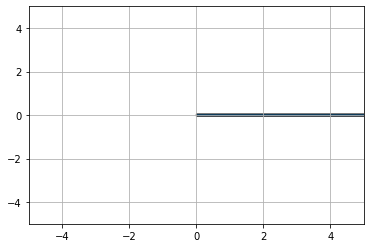

In [233]:
env.wind_vector()
plot_v_xz(env.wind_vector())
s = 5
plt.xlim(-s,s)
plt.ylim(-s,s)
plt.grid(True)

In [234]:
s0 = State(env = env)
s0.mass = 40;
s0.momentum = np.array([0,0,30*s0.mass])
q = Quaternion.from_angle(0, np.array([0,1,0]))
s0.quaternion = q

In [235]:
q

[1. 0. 0. 0.]

In [236]:
s0

State  [4.0e+01 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.2e+03 1.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]

In [237]:
s0.T_EB() @ r.ax_roll

array([0., 0., 1.])

In [238]:
r.v_body(s0)

array([ 0.,  0., 30.])

In [239]:
r.v_air_cg(s0)

array([ 10.,   0., -30.])

array([ 10.,   0., -30.])

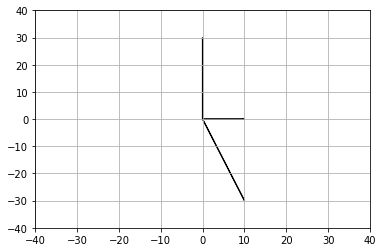

In [240]:
s=40
plot_v_xz(r.v_body(s0))
plot_v_xz(env.wind_vector())
plot_v_xz(r.v_air_cp(s0))
plt.xlim(-s,s)
plt.ylim(-s,s)
plt.grid()
r.v_air_cp(s0)

In [241]:
r.alpha(s0)*180/np.pi

18.434948822922017

In [242]:
r.normal(s0)

array([1., 0., 0.])

In [243]:
fn = r.f_normal(s0)
fn

array([13.93021398,  0.        , -0.        ])

In [244]:
r.cp

array([-0.   , -0.   , -0.225])

In [245]:
mn_b = np.cross(r.cp, fn)
mn_b

array([ 0.        , -3.13429815,  0.        ])

In [246]:
mn_e = s0.T_EB() @ mn_b
mn_e

array([ 0.        , -3.13429815,  0.        ])

In [247]:
s1 = State(quaternion=Quaternion(1,0,0,0), env=env)
s1.mass = 40
s1

State  [40.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]

In [248]:
sim = Simulation(r, s1)

In [249]:
sim.g

array([-0.  , -0.  , -9.81])

In [250]:
s1

State  [40.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]

In [251]:
r.dynamics(0, sim.state)

(array([   6.80077428,    0.        , 3999.45881158]),
 array([ 0.        , -1.53017421,  0.        ]),
 -2.0)

In [252]:
sol = sim.solve()

In [253]:
sol.message

'A termination event occurred.'

In [254]:
sol.success

True

In [255]:
sol;

In [256]:
sol.t_events

[array([0.33109995]), array([25.75397988]), array([57.57540407])]

Text(0.5, 1.0, 'Alpha')

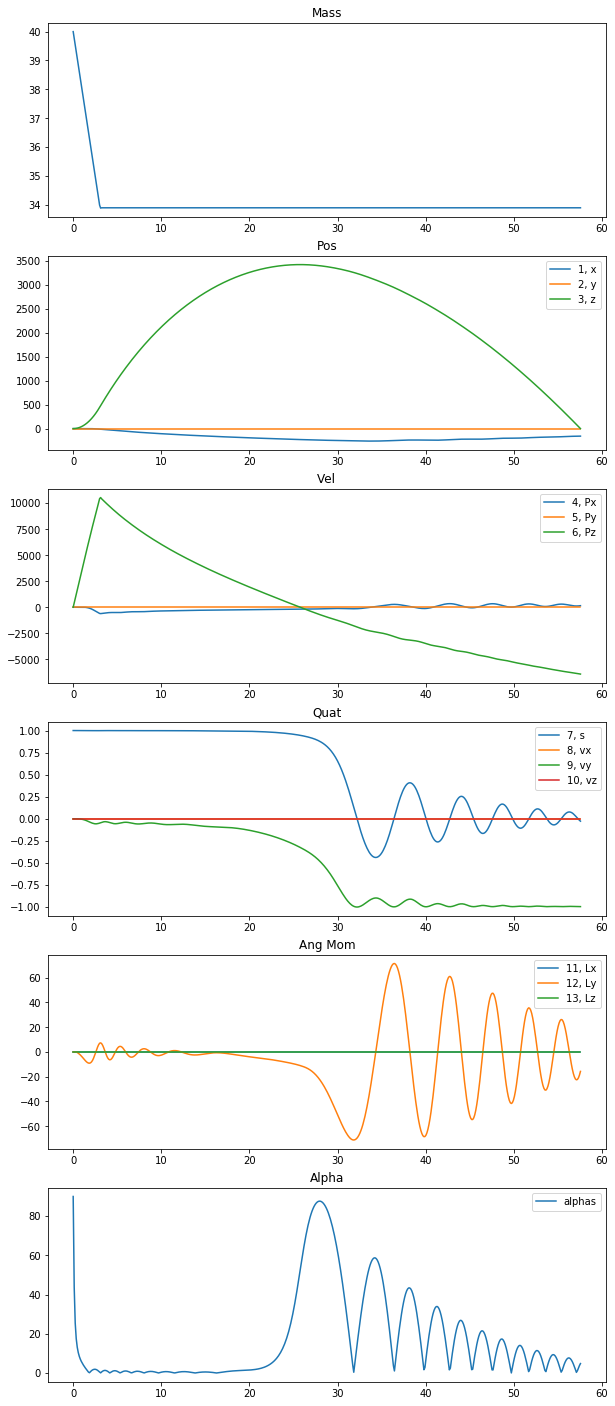

In [257]:
t_eval = np.linspace(sol.t[0], sol.t[-1], 500)


plt.figure(figsize=(10,25))
plt.subplot(611)
plt.plot(t_eval,sol.sol(t_eval)[0])

#for t in sol.t_events:
#    if len(t) is not 0:
#        plt.axvline(t, color='gray',linestyle='--')
    
plt.title('Mass')



plt.subplot(612)
plt.plot(t_eval,sol.sol(t_eval)[1], label='1, x')
plt.plot(t_eval,sol.sol(t_eval)[2], label='2, y')
plt.plot(t_eval,sol.sol(t_eval)[3], label='3, z')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
plt.legend()
plt.title('Pos')



plt.subplot(613)
plt.plot(t_eval,sol.sol(t_eval)[4], label='4, Px')
plt.plot(t_eval,sol.sol(t_eval)[5], label='5, Py')
plt.plot(t_eval,sol.sol(t_eval)[6], label='6, Pz')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Vel')



plt.subplot(614)
plt.plot(t_eval,sol.sol(t_eval)[7], label='7, s')
plt.plot(t_eval,sol.sol(t_eval)[8], label='8, vx')
plt.plot(t_eval,sol.sol(t_eval)[9], label='9, vy')
plt.plot(t_eval,sol.sol(t_eval)[10], label='10, vz')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Quat')



plt.subplot(615)
plt.plot(t_eval,sol.sol(t_eval)[11], label='11, Lx')
plt.plot(t_eval,sol.sol(t_eval)[12], label='12, Ly')
plt.plot(t_eval,sol.sol(t_eval)[13], label='13, Lz')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Ang Mom')


plt.subplot(616)
alphas = [r.alpha(s1.update(sol.sol(t), 0))*180/np.pi for t in t_eval]
plt.plot(t_eval,alphas, label='alphas')
#for t in sol.t_events:
#    plt.axvline(t, color='gray',linestyle='--')
    
plt.legend()
plt.title('Alpha')



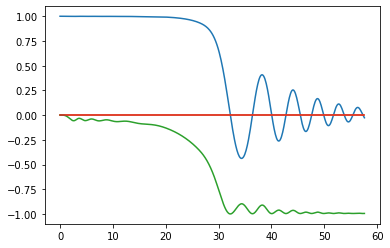

In [258]:
plt.plot(t_eval,sol.sol(t_eval)[7], label='7, s')
plt.plot(t_eval,sol.sol(t_eval)[8], label='8, vx')
plt.plot(t_eval,sol.sol(t_eval)[9], label='9, vy')
plt.plot(t_eval,sol.sol(t_eval)[10], label='10, vz')

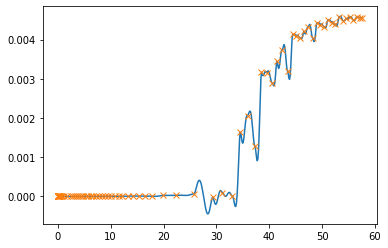

In [259]:
plt.plot(t_eval,[1-la.norm(sol.sol(t)[7:11]) for t in t_eval])
plt.plot(sol.t,[1-la.norm(sol.y[7:11,t]) for t in range(len(sol.t))], 'x')

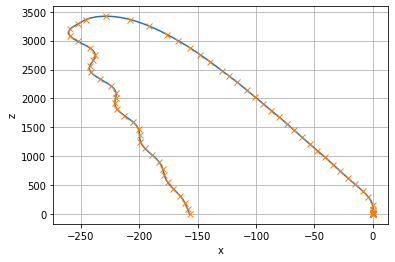

In [260]:
ax = plt.gca()
ax.plot(sol.sol(t_eval)[1], sol.sol(t_eval)[3])
ax.plot(sol.y[1], sol.y[3],'x')

plt.xlabel('x')
plt.ylabel('z')

#ax.set_aspect('equal', 'datalim')
plt.grid()

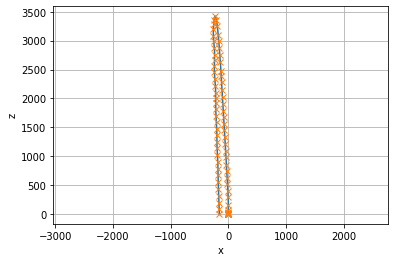

In [261]:
ax = plt.gca()
ax.plot(sol.sol(t_eval)[1], sol.sol(t_eval)[3])
ax.plot(sol.y[1], sol.y[3],'x')

plt.xlabel('x')
plt.ylabel('z')

ax.set_aspect('equal', 'datalim')
plt.grid()

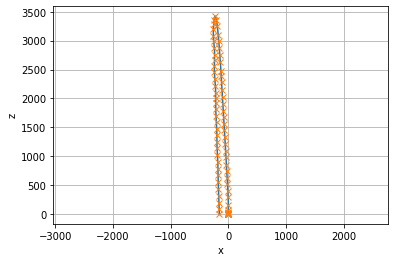

In [262]:
plt.plot(sol.sol(t_eval)[1], sol.sol(t_eval)[3])
plt.plot(sol.y[1], sol.y[3],'x')

plt.xlabel('x')
plt.ylabel('z')

ax = plt.gca()
ax.set_aspect('equal', 'datalim')
plt.grid()

(-3, 5)

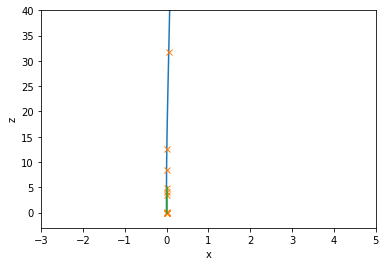

In [263]:
plt.plot(sol.sol(t_eval)[1], sol.sol(t_eval)[3])
plt.plot(sol.y[1], sol.y[3],'x')


plt.xlabel('x')
plt.ylabel('z')


xrail = [0, sim.launch_rail_length*np.sin(sim.launch_angle)]
zrail = [0, sim.launch_rail_length*np.cos(sim.launch_angle)]

xrail2 = [0, 10*sim.launch_rail_length*np.sin(sim.launch_angle)]
zrail2 = [0, 10*sim.launch_rail_length*np.cos(sim.launch_angle)]


plt.plot(xrail, zrail)

plt.ylim(-3,40)
plt.xlim(-3,5)


In [264]:
t_eval;

Text(0.5, 1.0, 'momentum angle')

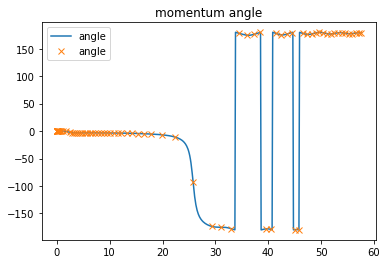

In [265]:
angle = 180*np.arctan2(sol.sol(t_eval)[4], sol.sol(t_eval)[6])/np.pi
angle_m = 180*np.arctan2(sol.y[4], sol.y[6])/np.pi

plt.plot(t_eval,angle, '-',label='angle')
plt.plot(sol.t,angle_m,'x', label='angle')
#for t in sol.t_events:
#    plt.axvline(t,linestyle='--',color='gray')
    
plt.legend()
plt.title('momentum angle')
#plt.xlim(0,3)
#plt.ylim(0,12)

/Users/Devansh/.virtualenvs/rocketPy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'orientation angle')

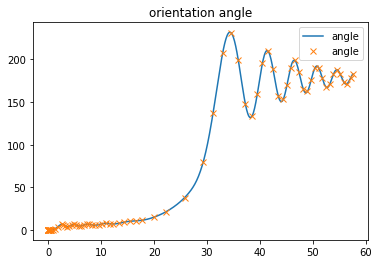

In [266]:
angle_quat = (180/np.pi)*2*np.arccos(sol.sol(t_eval)[7])
angle_m = (180/np.pi)*2*np.arccos(sol.y[7])

plt.plot(t_eval,angle_quat, '-',label='angle')
plt.plot(sol.t,angle_m,'x', label='angle')
#for t in sol.t_events:
#    plt.axvline(t,linestyle='--',color='gray')
    
plt.legend()
plt.title('orientation angle')
#plt.xlim(0,3)
#plt.ylim(0,12)

In [118]:
angle_quat

array([  6.        ,   6.00005899,   6.00027178,   6.00002102,
         5.99842385,   5.99442513,   5.98769924,   5.97839456,
         5.96674   ,   5.95319051,   5.93826744,   5.92230455,
         5.90706559,   5.89443401,   5.88620775,   5.88408767,
         5.88966188,   5.90438716,   5.92956902,   5.96629775,
         6.01447335,   6.07360544,   6.14224518,   6.21767161,
         6.29607723,   6.37327362,   6.4444868 ,   6.50517565,
         6.55150468,   6.58131985,   6.59487288,   6.59440495,
         6.58303018,   6.56496878,   6.54489489,   6.52722852,
         6.51591744,   6.51396787,   6.52362093,   6.54595381,
         6.5805169 ,   6.62578188,   6.67986565,   6.74026861,
         6.80393982,   6.86752023,   6.92836478,   6.98401338,
         7.03268232,   7.07330009,   7.10556281,   7.12965445,
         7.1462977 ,   7.15686547,   7.16335048,   7.16768641,
         7.17182143,   7.17765118,   7.18690828,   7.20107964,
         7.22115053,   7.24785707,   7.28143892,   7.32

In [119]:
sol.sol(t_eval)

array([[4.00000000e+01, 3.97768234e+01, 3.95536468e+01, ...,
        3.40218631e+01, 3.40218631e+01, 3.40218631e+01],
       [0.00000000e+00, 5.86125141e-02, 2.35096156e-01, ...,
        1.00305345e+03, 1.00411049e+03, 1.00518039e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.68764844e-03, 3.76603509e-03, ...,
        1.61664389e+01, 1.77889263e+01, 1.86099313e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [120]:
sol.y

array([[ 4.00000000e+01,  3.99999990e+01,  3.99999895e+01,
         3.99998942e+01,  3.99989408e+01,  3.99894072e+01,
         3.98940709e+01,  3.89407077e+01,  3.78815373e+01,
         3.58166081e+01,  3.47427234e+01,  3.40820782e+01,
         3.40218631e+01,  3.40218631e+01,  3.40218631e+01,
         3.40218631e+01,  3.40218631e+01,  3.40218631e+01,
         3.40218631e+01,  3.40218631e+01,  3.40218631e+01,
         3.40218631e+01,  3.40218631e+01,  3.40218631e+01,
         3.40218631e+01,  3.40218631e+01,  3.40218631e+01,
         3.40218631e+01,  3.40218631e+01,  3.40218631e+01,
         3.40218631e+01,  3.40218631e+01,  3.40218631e+01,
         3.40218631e+01,  3.40218631e+01,  3.40218631e+01,
         3.40218631e+01,  3.40218631e+01,  3.40218631e+01,
         3.40218631e+01,  3.40218631e+01,  3.40218631e+01,
         3.40218631e+01,  3.40218631e+01,  3.40218631e+01,
         3.40218631e+01,  3.40218631e+01,  3.40218631e+01,
         3.40218631e+01,  3.40218631e+01,  3.40218631e+0

In [121]:
sol.t

array([0.00000000e+00, 4.76681586e-07, 5.24349745e-06, 5.29116561e-05,
       5.29593242e-04, 5.29640910e-03, 5.29645677e-02, 5.29646154e-01,
       1.05923135e+00, 2.09169597e+00, 2.62863832e+00, 2.95896092e+00,
       3.28928353e+00, 3.66773781e+00, 4.01451628e+00, 4.45705707e+00,
       4.95572288e+00, 5.45599197e+00, 5.98933848e+00, 6.51409984e+00,
       7.00213603e+00, 7.65481264e+00, 8.31473570e+00, 9.09023430e+00,
       9.85968451e+00, 1.08457753e+01, 1.18244790e+01, 1.29209585e+01,
       1.44001567e+01, 1.63200072e+01, 1.80989186e+01, 2.04463315e+01,
       2.40020054e+01, 2.95851574e+01, 3.10963159e+01, 3.26074744e+01,
       3.40922747e+01, 3.55770750e+01, 3.69882658e+01, 3.81476546e+01,
       3.92868236e+01, 4.04062098e+01, 4.14148365e+01, 4.23782555e+01,
       4.32996810e+01, 4.42167338e+01, 4.50969910e+01, 4.59004141e+01,
       4.66639927e+01, 4.74418805e+01, 4.82557856e+01, 4.90060498e+01,
       4.97383939e+01, 5.04219436e+01, 5.11295245e+01, 5.18515453e+01,
      

In [122]:
sol.t_events

[array([0.33097754]), array([], dtype=float64), array([55.68256399])]

In [123]:
s0

State  [4.0e+01 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.2e+03 1.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]

In [124]:
sol.y_events[1]

array([], dtype=float64)

In [125]:
s0

State  [4.0e+01 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.2e+03 1.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]

In [126]:
s0.update(sol.y_events[1][0], sol.t_events[1])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
sol.y_events[1][0]

In [ ]:
s0

In [ ]:
s0.mass

In [127]:
s0.pos

array([0, 0, 0])

In [128]:
s0.momentum

array([   0,    0, 1200])

In [129]:
r.alpha(s0)*180/np.pi

1.9091524329963898